## Desafío 2: Rendimiento escolar

Lo contactan de una escuela Portuguesa para generar un modelo que identifique aquellos alumnos que presentan un bajo desempeño académico, medido en el promedio final del año escolar. Para ello le envían un archivo con registros sociodemográficos y conductuales de los alumnos de dos escuelas para perfilar a los estudiantes.

De manera adicional la psicopedagoga sugiere inspeccionar una batería de preguntas asociadas a aspectos ambientales del alumno (de famrel a health) y ver si éstas se pueden abstraer en categorías latentes.

In [ ]:
# Dada la información vamos a abacar el problema desde una regresión ya que la variable objetivo es continua.
# Se buscará predecir, según los atributos personales y ambientales de cada estudiante, su promedio final.

# Se utilizarán métricas como coef_, Mean Squared Error (MSE) y R2 de la librería metrics de ScikitLearn 
# para determinar el desempeño del modelo propuesto

#### HITO 1 : PRELIMINARES

Elementos a considerar en éste hito:
- Los dos enunciados deben estar claros, considerando el tipo de problema a resolver (regresión o clasificación).Para cada uno de los enunciados y su problema identificado, se debe justificar el uso de métricas para medir el desempeño del problema. (6 puntos)
- Se debe considerar el uso de las librerías asociadas para la ingesta, preprocesamiento, visualización y modelación, así como métricas de evaluación. (2 puntos)
- Se debe detallar y considerar el proceso de preprocesamiento y recodificación de datos. (2 puntos)

In [273]:
# Librerías ingesta de datos
import pandas as pd
import numpy as np

# Librerías visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías preprocesamiento y modelado
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import missingno as msngo

# Para detectar factores latentes
import factor_analyzer as factor

# Librerías otros
import warnings
import Funciones as fx

# Ignorar advertencias para mantener el notebook limpio
warnings.filterwarnings('ignore')
# Parámetros visuales de los gráficos
plt.rcParams['figure.figsize'] = (15, 10)
sns.color_palette("pastel")

# Lectura de base da datos (csv)
df = pd.read_csv('CSV/students.csv', delimiter='|',index_col=0)

In [130]:
# Revisión visual del DataFrame
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4,4,at_home,teacher,...,4,3,4.0,1,1,3.0,6,5,6,6
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,...,5,3,3.0,1,1,3.0,4,5,5,6
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,...,4,3,2.0,2,3,3.0,10,NaN,8,10
3,GP,F,15.0,U,GT3,T,4,2,health,services,...,3,2,2.0,1,1,5.0,2,15,14,15
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,4,3,2.0,1,2,5.0,4,6,10,10


In [212]:
# Eliminar nulos
nulos = ['sem validade','zero','nulidade']
for columna in df.columns:
    df[columna] = df[columna].replace(nulos, [np.nan, np.nan, np.nan])
    
# Cambiar tipo de dato: Object > float
for columna in ['G1','G2','G3']:
    df[columna] = df[columna].map(lambda x: float(x))

# Cambiar datos string a float
for columna in ['age','goout','health','Dalc','Walc','freetime','famrel']:
    df[columna] = df[columna].str.replace('"', "").astype('float')

In [213]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4,4,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10,NaN,8.0,10.0
3,GP,F,15.0,U,GT3,T,4,2,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2,15.0,14.0,15.0
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4,6.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20.0,U,LE3,A,2,2,services,services,...,5.0,5.0,4.0,4.0,5.0,4.0,11,9.0,9.0,9.0
391,MS,M,17.0,U,LE3,T,3,1,services,services,...,2.0,4.0,5.0,3.0,4.0,2.0,3,14.0,16.0,16.0
392,MS,M,21.0,R,GT3,T,1,1,other,other,...,5.0,5.0,3.0,3.0,3.0,3.0,3,10.0,8.0,7.0
393,MS,M,18.0,R,LE3,T,3,2,services,other,...,4.0,4.0,1.0,3.0,4.0,5.0,0,11.0,12.0,10.0


In [214]:
# Copia del df original
df_recod = df.copy()

# Revisión de valores de variables binarias.
binarias = ['school','sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

for columna in binarias:
    data = pd.DataFrame(df_recod[columna].value_counts())

    if data[columna][0] > data[columna][1]:
        df_recod[columna] = df_recod[columna].replace([data[columna].index[0],data[columna].index[1]],[0,1])
        print(f'En columna {columna}: {data[columna].index[0]} es mayor')
    else:
        df_recod[columna] = df_recod[columna].replace([data[columna].index[0],data[columna].index[1]],[1,0])
        print(f'En columna {columna}: {data[columna].index[1]} es mayor')

En columna school: GP es mayor
En columna sex: F es mayor
En columna address: U es mayor
En columna famsize: GT3 es mayor
En columna Pstatus: T es mayor
En columna schoolsup: no es mayor
En columna famsup: yes es mayor
En columna paid: no es mayor
En columna activities: yes es mayor
En columna nursery: yes es mayor
En columna higher: yes es mayor
En columna internet: yes es mayor
En columna romantic: no es mayor


In [215]:
from sklearn.preprocessing import LabelEncoder

# Recodificación de variables con 2 o más valores
df_recod['Mjob_enc'] = LabelEncoder().fit_transform(df_recod['Mjob'])
df_recod['Fjob_enc'] = LabelEncoder().fit_transform(df_recod['Fjob'])
df_recod['reason_enc'] = LabelEncoder().fit_transform(df_recod['reason'])
df_recod['guardian_enc'] = LabelEncoder().fit_transform(df_recod['guardian'])

df_recod = df_recod.dropna()

#### HITO 2 : DESCRIPCIÓN
Elementos a considerar en éste hito:
   - La inspección visual del vector objetivo. (4 puntos)
   - La inspección visual de las variables. (4 puntos)
   - La inspección de datos perdidos en las variables. (2 puntos)
   - De ser necesario, se puede iterar en el proceso de preprocesamiento y recodificación de las variables.

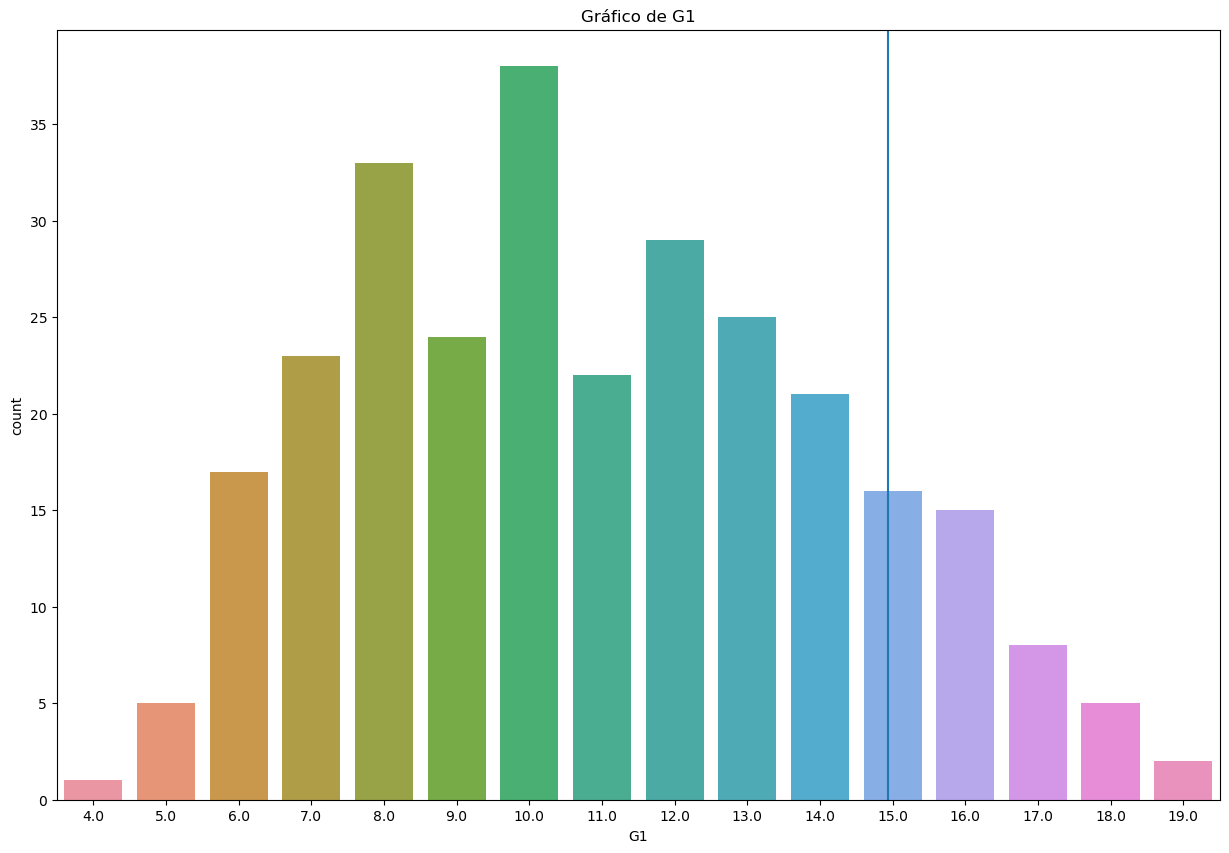

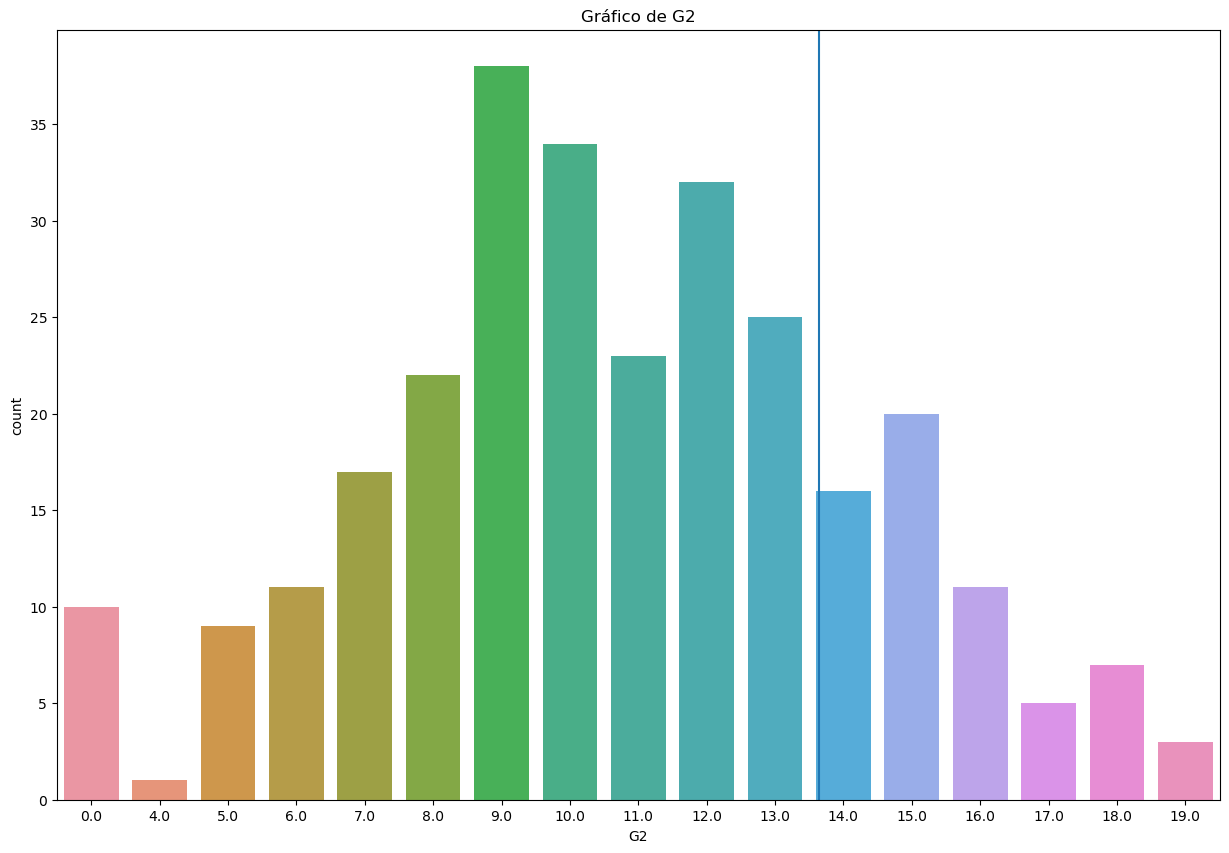

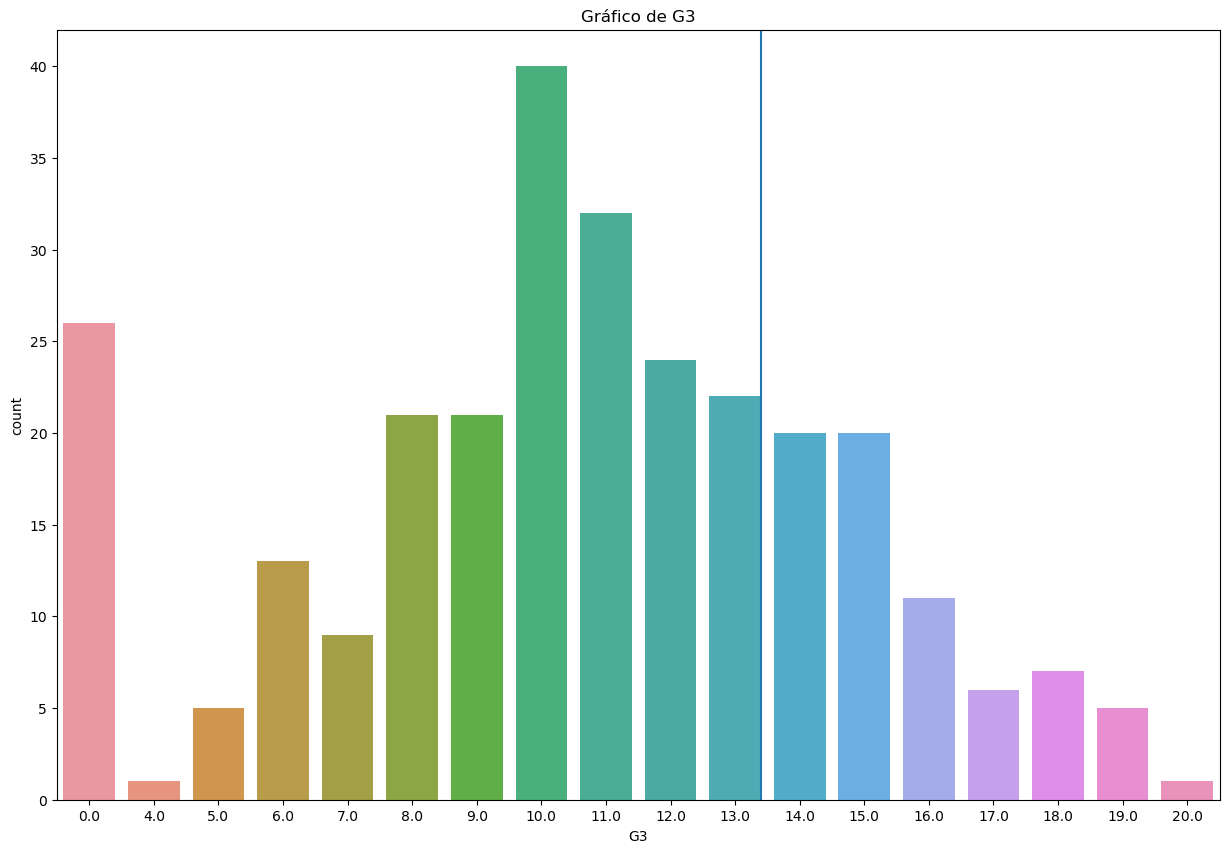

In [216]:
# Visualización de gráficos
for columna in ['G1', 'G2', 'G3']:
    sns.countplot(data=df_recod, x=columna)
    plt.axvline(df_recod[columna].mean())
    plt.title(f'Gráfico de {columna}')
    plt.show()

In [173]:
# Hay que observar que el promedio de las notas G1 y G2, o sea G3 aparece un 0.0 para algunos estudiantes.
# Por lo que habría que revisar la data para verificar la información y eliminarla al momento de armar el
# modelo. 
# La mayor parte de los estudiantes se encuentran bajo la media en las 3 clasificaciones.

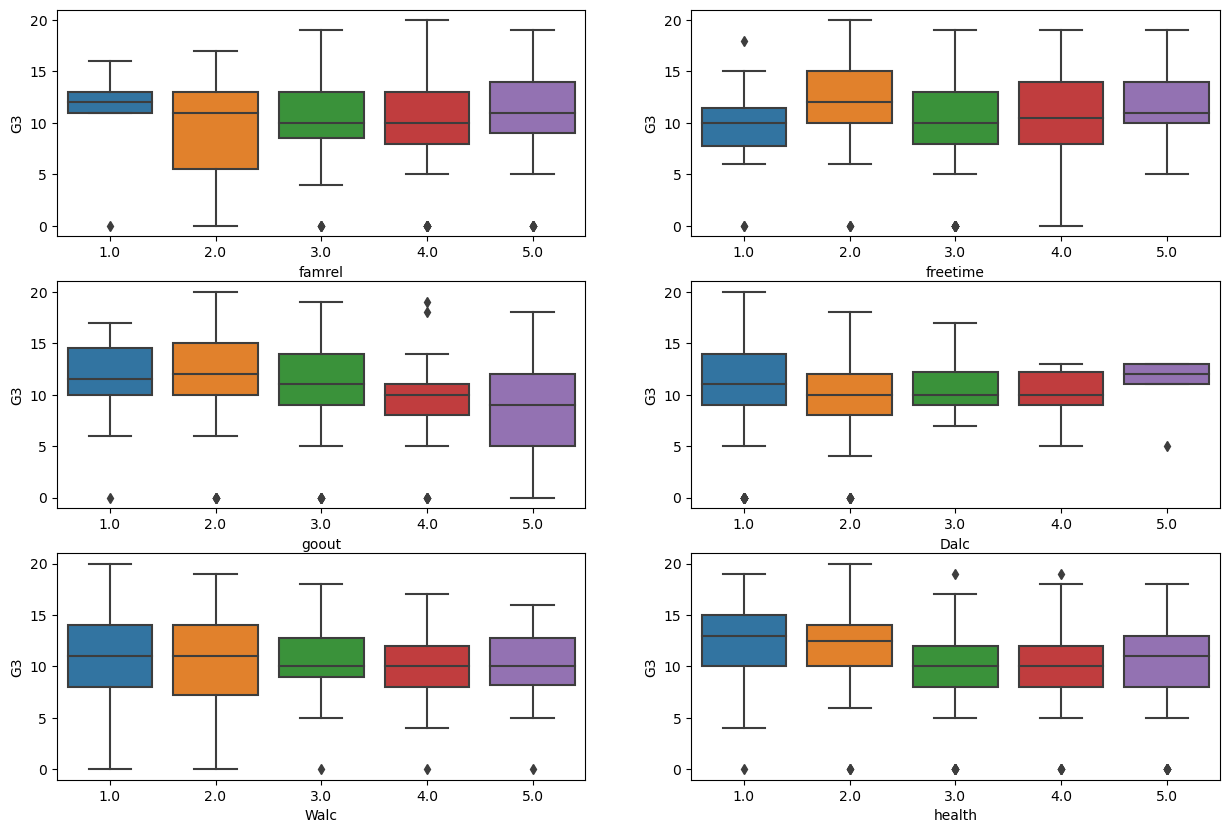

In [217]:
# Mostrar gráficos de las variables que se proponen revisar
variables_df = ['famrel','freetime','goout','Dalc','Walc','health']
for index, variable in enumerate(variables_df):
    plt.subplot(3,2,index+1)
    sns.boxplot(x=df_recod[variable], y=df_recod['G3'])

In [183]:
# Se ve en los gráficos que el consumo de alcohol es mayor los fines de semana pero afecta mayormente a G3 cuando
# es durante la semana. 
# Para los estudiantes que salen más, se ve un G3 más bajo que el resto de los estudiantes pero aún cercano a la
# media.
# Respecto al tiempo libre de los estudiantes, aquellos que tienen más tiempo libre obtienen mejor G3, aunque
# se ve una equidad con aquellos estudaintes que perciben tener menos tiempo libre, siendo equilibrado.

<AxesSubplot:>

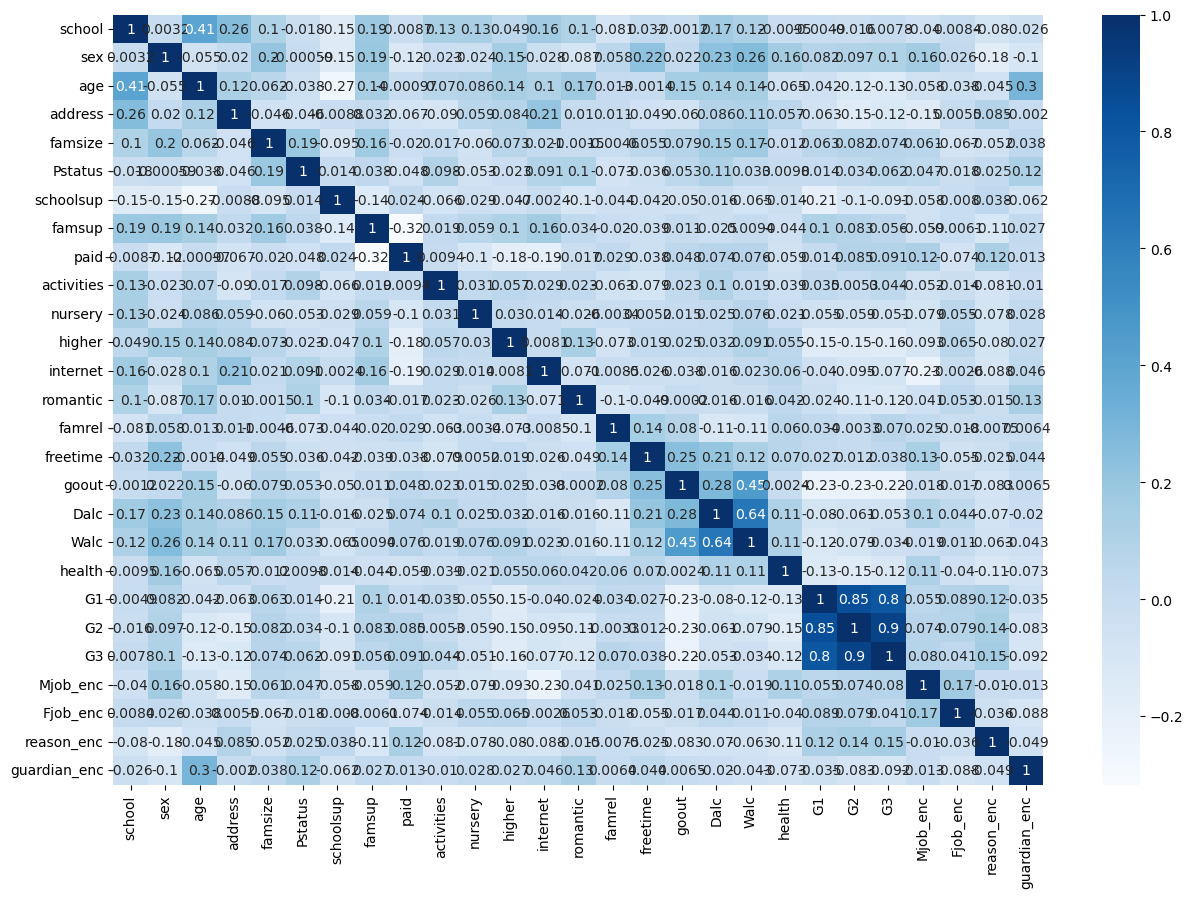

In [218]:
# Observaremos las correlaciones
sns.heatmap(df_recod.corr(), cmap="Blues", annot=True)

In [186]:
# Se ve una relación entre las clases pagadas y el apoyo familiar del estudiante y su deseos de seguir 
# en estudios superiores.
# Para las tres evaluaciones se ve una relación entre 'goout', 'health', 'schoolsup'. En general se ven bajas
# correlaciones. El tomar durante la semana se relaciona con salir y beber en la semana.

In [222]:
# Realizaremos la prueba Kaiser-Meyer-Olkin para observar si correlaciones entre dos items son cercanas a cero.
# Tomaremos los factores ambientales propuestos anteriormente.
df_factor = df_recod[['famrel','freetime','goout','Dalc','Walc','health']]
factor_kmo = factor.calculate_kmo(df_factor)[0]
pd.DataFrame(data={'Columna': df_factor.columns,'KMO': factor_kmo})

,Columna,KMO
0,famrel,0.501733
1,freetime,0.576923
2,goout,0.616840
3,Dalc,0.586642
4,Walc,0.555409
5,health,0.592659


In [223]:
# Los KMO de cada variable son menores a 0.7, podemos decir que no existe un factor latente que afecte
# directamente el promedio de G3 que queremos predecir.

<AxesSubplot:>

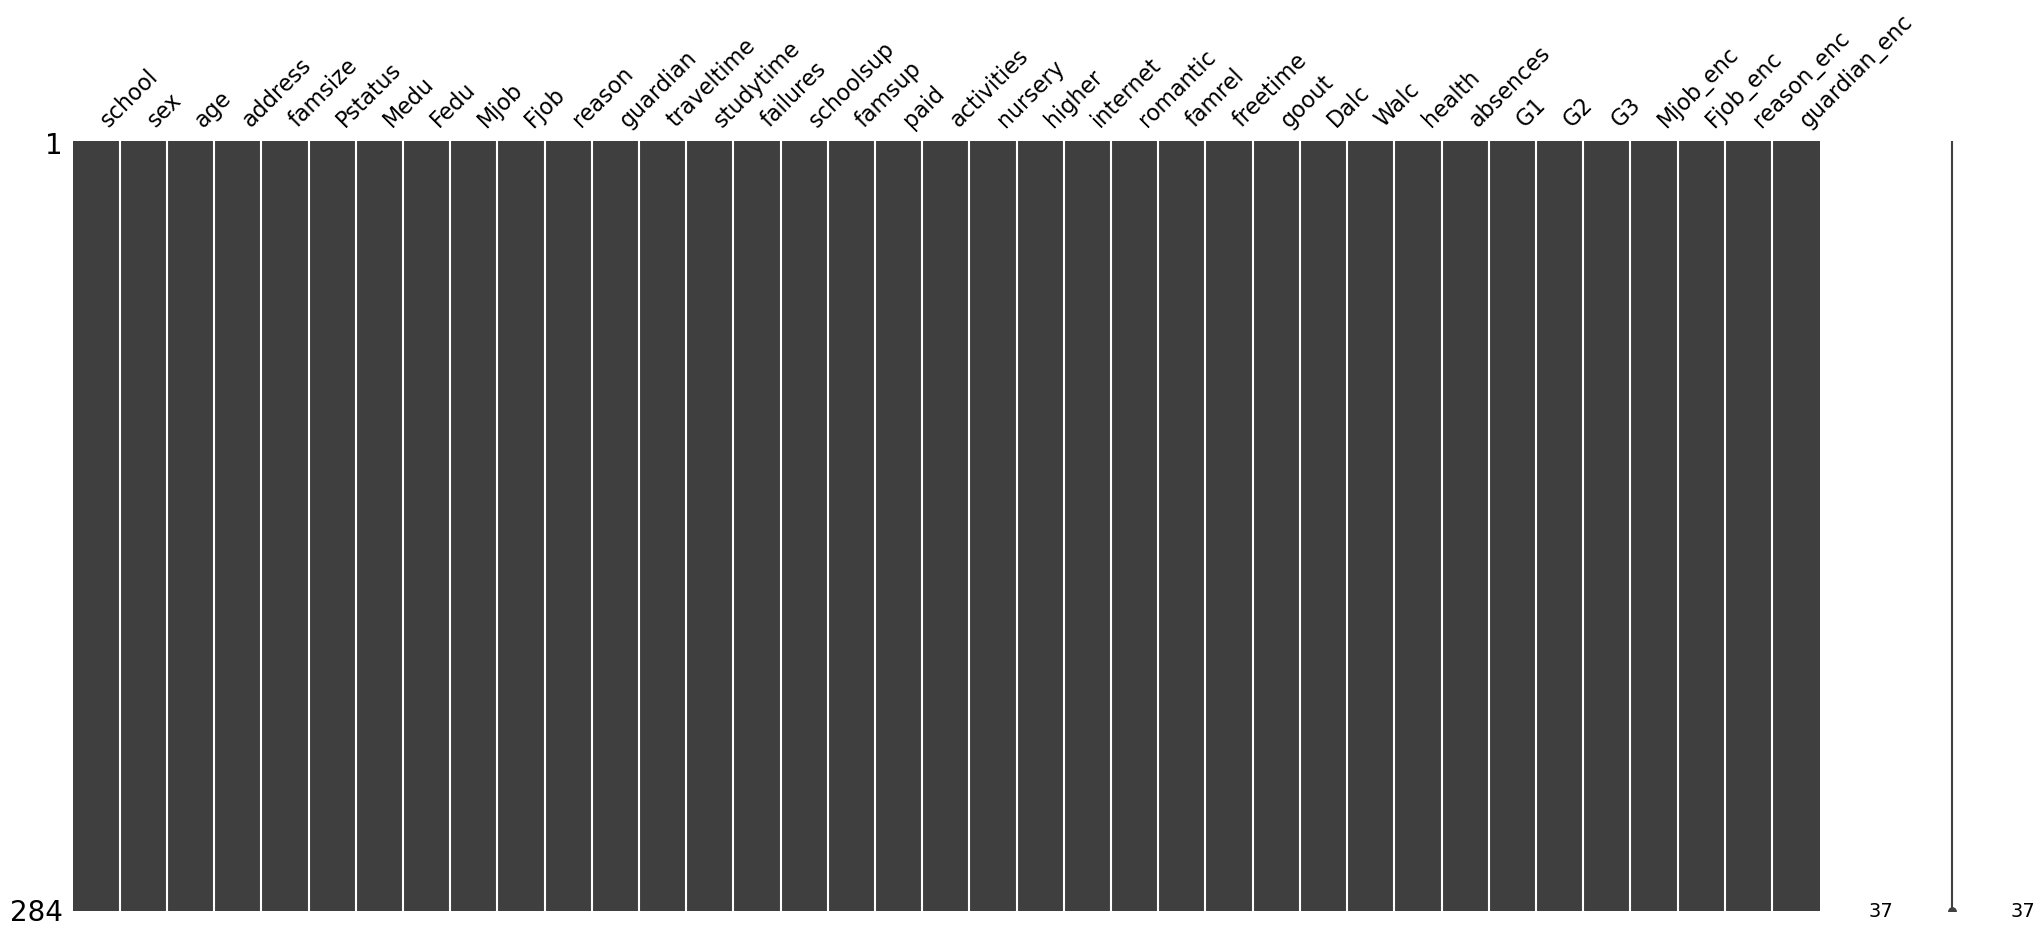

In [224]:
# Observaremos datos perdidos antes de pasar a la modelación.
msngo.matrix(df_recod)

In [188]:
# Luego de recodificar y tratar nuestros datos no se observan datos perdidos pero para asegurarnos de que
# nuestro modelo funcione mejor vamos a reemplazar los valores 0.0 de G1, G2 y G3 por la media de cada columna.

In [202]:
# Cambio de valores.
for columna in ['G1','G2','G3']:
    df_recod[columna] = df_recod[columna].replace(0.0, df_recod[columna].mean())

### HITO 3 : MODELACIÓN DESCRIPTIVA

Elementos a considerar
   - La modelación mediante regresión de ambos problemas. (4 puntos)
   - La interpretación de los principales regresores en cada problema. (4 puntos)
   - La definición de las estrategias de Modelación predictiva. (2 puntos)   

In [255]:
def cadena_modelo(data, variable):
    '''
    Esta función recibe el dataframe y un string con la variable que no se debe incluir.

            Parameters:
                    a (DataFrame): DataFrame de donde se obtendrán las columnas.
                    b (list): Lista de variable que no se desea considerar en la cadena.

            Returns:
                    (str): Se retorna una cadena de texto con formato para el modelo ej: 'str + str'
    '''
    txt = ''
    for columna in data.columns:
        if columna in variable:        
            None
        else:
            txt = txt+columna+' + '
    txt = txt[:-3]
    return txt
    

In [256]:
cadena = cadena_modelo(df_recod, ['G1'])
model_g1 = smf.ols('G1 ~ {}'.format(cadena), data=df_recod).fit()
model_g1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     11.75
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           2.25e-45
Time:                        15:52:11   Log-Likelihood:                -489.11
No. Observations:                 284   AIC:                             1146.
Df Residuals:                     200   BIC:                             1453.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2312      3.317     -0.070      0.945      -6.772       6.310
Medu[T.1]                0.5024      1.791      0.280      0.779      -3.030       4.035
Medu[T.2]                0.4354      1.759      0.248      0.805      -3.033       3.904
Medu[T.3]               -0.0754      1.769     -0.043      0.966      -3.564       3.413
Medu[T.4]                0.2288      1.789      0.128      0.898      -3.298       3.756
Fedu[T.1]                0.9010      1.753      0.514      0.608      -2.556       4.358
Fedu[T.2]                1.3552      1.785      0.759      0.449      -2.164       4.874
Fedu[T.3]                1.4197      1.779      0.798      0.426      -2.089       4.929
Fedu[T.4]                1.7789      1.813      0.981      0.328      -1.795       5.353
Mjob[T.health]           0.2610      0.468      0.558      0.577      -0.661       1.183
Mjob[T.other]           -0.4334      0.237     -1.829      0.069      -0.901       0.034
Mjob[T.services]         0.3123      0.227      1.375      0.171      -0.135       0.760
Mjob[T.teacher]         -0.1008      0.218     -0.463      0.644      -0.530       0.329
Fjob[T.health]          -0.7319      0.647     -1.132      0.259      -2.007       0.543
Fjob[T.other]           -0.5465      0.296     -1.846      0.066      -1.130       0.037
Fjob[T.services]        -0.4484      0.242     -1.856      0.065      -0.925       0.028
Fjob[T.teacher]          0.7617      0.296      2.571      0.011       0.178       1.346
reason[T.home]           0.1754      0.247      0.710      0.479      -0.312       0.663
reason[T.other]         -0.4265      0.286     -1.493      0.137      -0.990       0.137
reason[T.reputation]     0.2209      0.178      1.242      0.216      -0.130       0.572
guardian[T.mother]       0.0568      0.248      0.229      0.819      -0.432       0.545
guardian[T.other]       -0.0403      0.173     -0.233      0.816      -0.381       0.300
traveltime[T.2]          0.0317      0.262      0.121      0.904      -0.485       0.548
traveltime[T.3]          0.8252      0.503      1.640      0.103      -0.167       1.817
traveltime[T.4]          0.0906      0.860      0.105      0.916      -1.604       1.786
studytime[T.2]           0.0533      0.289      0.184      0.854      -0.517       0.623
studytime[T.3]           0.6334      0.379      1.670      0.096      -0.114       1.381
studytime[T.4]           0.9548      0.506      1.885      0.061      -0.044       1.954
failures[T.1]           -0.8125      0.391     -2.078      0.039      -1.584      -0.041
failures[T.2]            0.1740      0.605      0.288      0.774      -1.019       1.366
failures[T.3]           -0.5698      0.629     -0.906      0.366      -1.810       0.671
absences[T.1]           -1.3765      1.046     -1.316    

In [270]:
# Se consideraran las variables que tengan p-value < 0.05 o cercanas. Por lo tanto nos quedaremos con:
# 'schoolsup','failures' y agregaremos algunas variables.

model_g1 = smf.ols('G1 ~ schoolsup + studytime + health + failures + goout', data=df_recod).fit()
model_g1.summary()

# Acá nos acomodamos con algunas variables con la finalidad de buscar un mejor resultado del modelo.
# El modelo actual posee un r2 de 20% aprox. Utilizaremos las mismas variables con la siguiente variable G2.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     8.155
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           9.89e-11
Time:                        16:05:46   Log-Likelihood:                -706.92
No. Observations:                 284   AIC:                             1434.
Df Residuals:                     274   BIC:                             1470.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.3943      0.820     17.554      0.000      12.780      16.009
studytime[T.2]    -0.4751      0.434     -1.094      0.275      -1.330       0.380
studytime[T.3]     0.5201      0.550      0.945      0.346      -0.564       1.604
studytime[T.4]     0.6012      0.776      0.775      0.439      -0.926       2.129
failures[T.1]     -1.1437      0.538     -2.127      0.034      -2.202      -0.085
failures[T.2]     -2.6369      0.822     -3.208      0.001      -4.255      -1.019
failures[T.3]     -3.8102      0.985     -3.869      0.000      -5.749      -1.871
schoolsup         -2.0447      0.521     -3.925      0.000      -3.070      -1.019
health            -0.2819      0.136     -2.075      0.039      -0.549      -0.014
goout             -0.5359      0.169     -3.169      0.002      -0.869      -0.203
==============================================================================
Omnibus:                       11.101   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.218
Skew:                           0.171   Prob(JB):                       0.0446
Kurtosis:                       2.360   Cond. No.                         29.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [271]:
model_g2 = smf.ols('G2 ~ schoolsup + health + failures + goout', data=df_recod).fit()
model_g2.summary()
# Sacamos 'studytime' ya que psu p-value es muy alto.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     9.556
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.49e-09
Time:                        16:05:49   Log-Likelihood:                -754.10
No. Observations:                 284   AIC:                             1522.
Df Residuals:                     277   BIC:                             1548.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.7864      0.860     17.187      0.000      13.093      16.480
failures[T.1]    -0.8318      0.628     -1.325      0.186      -2.068       0.404
failures[T.2]    -3.7022      0.962     -3.849      0.000      -5.596      -1.809
failures[T.3]    -4.1465      1.142     -3.630      0.000      -6.395      -1.898
schoolsup        -1.2989      0.609     -2.133      0.034      -2.498      -0.100
health           -0.3784      0.158     -2.395      0.017      -0.689      -0.067
goout            -0.7011      0.197     -3.563      0.000      -1.088      -0.314
==============================================================================
Omnibus:                       15.915   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.263
Skew:                          -0.496   Prob(JB):                     0.000108
Kurtosis:                       3.747   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [272]:
model_g3 = smf.ols('G3 ~ schoolsup + health + failures + goout', data=df_recod).fit()
model_g3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     9.356
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           2.37e-09
Time:                        16:14:18   Log-Likelihood:                -807.56
No. Observations:                 284   AIC:                             1629.
Df Residuals:                     277   BIC:                             1655.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.7047      1.039     14.159      0.000      12.660      16.749
failures[T.1]    -1.2695      0.758     -1.675      0.095      -2.761       0.222
failures[T.2]    -4.5526      1.161     -3.921      0.000      -6.838      -2.267
failures[T.3]    -5.7147      1.379     -4.144      0.000      -8.429      -3.000
schoolsup        -1.3553      0.735     -1.844      0.066      -2.802       0.092
health           -0.3192      0.191     -1.674      0.095      -0.695       0.056
goout            -0.7717      0.238     -3.249      0.001      -1.239      -0.304
==============================================================================
Omnibus:                       30.319   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.438
Skew:                          -0.794   Prob(JB):                     7.42e-09
Kurtosis:                       3.800   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Para cada modelo de variables los modelos van representando un poco menos, su valor r2 va disminuyendo.
# En el siguiente paso realizaremos la división de muestras para entrenamiento y testeo en el modelo
# predictivo. Luego ajustaremos el modelo para realizar la predicción.

### HITO 4

Elementos a considerar
   - La preparación del ambiente de trabajo (imports, separación de muestras) para implementar modelos de predicción. (2 puntos)
   - La implementación de por lo menos tres modelos predictivos. (4 puntos)
   - El reporte del mejor modelo predictivo en base a los resultados. (4 puntos)

### ** MODELO 1 **

In [288]:
def informe_predictivo(data, variables, var_obj):
    '''
    Esta función recibe un DataFrame, variables y la variable objetivo para generar un informe del modelo de
    Regresión Lineal

            Parameters:
                    a (DataFrame): DataFrame de donde se sacará la información de las columnas.
                    b (list): Lista con las variables que se desean agregar al modelo.
                    c (str): Nombre de la variable objetivo.

            Returns:
                    print con el reporte MSE y R2
    '''
    X_train, X_test, y_train, y_test = train_test_split(data[variables],data[var_obj], test_size=.7, random_state=89)
    modelo = LinearRegression().fit(X_train, y_train)

    # Predicción
    y_pred_test = modelo.predict(X_test)

    # Evaluación de desempeño
    y_pred_train = modelo.predict(X_train)
    mse_modelo_train = mean_squared_error(y_true=y_train, y_pred=y_pred_train)
    r2_modelo_train = r2_score(y_true=y_train, y_pred=y_pred_train)
    print(f'MSE: {mse_modelo_train}   R2: {r2_modelo_train}')

In [285]:
# Preparación de los datos para el modelo predictivo
variables = ['schoolsup','health','failures','goout']
informe_predictivo(df_recod, variables, 'G3')

MSE: 15.719625777734459   R2: 0.21696660155448377


In [279]:
# Este modelo explica el 20% de los resultados de G3 si nos guiamos por su r2. Probaremos otros modelos sacando
# algunas variables y agregando otras.

### ** MODELO 2 **

In [286]:
variables = ['schoolsup','famsup','failures','goout','freetime']
informe_predictivo(df_recod, variables, 'G3')

MSE: 15.299783433224675   R2: 0.23787998603838645


In [282]:
# Este segundo modelo le sumó un 2% al modelo anterior, manteniendo el rango de MSE my similar y bajando un poco.
# Probaremos un tercer modelo incoporando variables que fueron dejadas afuera por sus p-value en modelos anteriores.

### ** MODELO 3 **

In [287]:
variables = ['schoolsup','famsup','failures','goout','freetime','Dalc','Walc']
informe_predictivo(df_recod, variables, 'G3')

MSE: 14.912073834927913   R2: 0.25719275904308925


In [ ]:
# Se puede observar un modelo con más variables y mejor r2, lo que explicaría el 25% del modelo en G3.
# Se incorporaron variables que anteriormente no fueron consideradas por su p-value y ahora suman al valor del
# modelo. Pensaría en quedarme con este modelo.